# LDA para o Documento Curricular do Tocantins para Educação Infantil e Ensino Fundamental:

## Importação das bibliotecas:

In [29]:
# Para ler o PDF:
import PyPDF2

# Para analisar o layout do PDF e extrair o texto:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

# Para extrair textos de tabelas em PDF:
import pdfplumber

# Para extrair as imagens dos PDFs:
from PIL import Image
from pdf2image import convert_from_path

# Para fazer Reconhecimento Ótico de Caracteres (OCR) para extrair textos das imagens:
import pytesseract

# Para remover os arquivos adicionais criados:
import os

# Para manipulação e análise dos dados:
import pandas as pd
import numpy as np
from collections import Counter

# Para acompanhar a execução dos códigos:
from tqdm import tqdm

# Para análise dos dados textuais:
import re
import nltk
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

# Para visualizações:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [30]:
# Download do modelo para língua portuguesa:
spacy.cli.download("pt_core_news_lg")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


In [31]:
# Carregamento do modelo:
nlp = spacy.load('pt_core_news_lg')

## 1. Extração das informações do PDF:

In [32]:
# Caminho do arquivo em PDF:
pdf_path = r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Dissertação PROFIAP\LDA\TO\TO_curriculo_EIEF.pdf"

In [55]:
def extrair_texto_pdf(nome_arquivo):
    with open(nome_arquivo, 'rb') as file:
        leitor_pdf = PyPDF2.PdfReader(file)
        num_paginas = len(leitor_pdf.pages)
        texto_por_pagina = []

        for pagina_num in tqdm(range(num_paginas), desc="Extraindo texto"):
            pagina = leitor_pdf.pages[pagina_num]
            texto = pagina.extract_text()
            texto_por_pagina.append(texto)

    return texto_por_pagina

def criar_dataframe(texto_por_pagina):
    df = pd.DataFrame({"Página": range(1, len(texto_por_pagina) + 1), "Texto": texto_por_pagina})
    return df

if __name__ == "__main__":
    pdf_path = r"C:\Users\hugob\Dropbox\Hugo_Bovareto\Dissertação PROFIAP\LDA\TO\TO_curriculo_EIEF.pdf"
    texto_por_pagina = extrair_texto_pdf(pdf_path)
    df = criar_dataframe(texto_por_pagina)

# Exibir o DataFrame:
df

Extraindo texto: 100%|███████████████████████████████████████████████████████████████| 772/772 [00:21<00:00, 36.73it/s]


,Página,Texto
0,1,
1,2,
2,3,DOCUMENTO CURRICULAR\nTOCANTINS\nEDUCAÇÃO \nIN...
3,4,
4,5,GOVERNO FEDERAL\nJair Messias Bolsonaro\nPresi...
...,...,...
767,768,Documento Curricular | Tocantins | Ensino Reli...
768,769,Documento Curricular | Tocantins | Ensino Reli...
769,770,Documento Curricular | Tocantins | Ensino Reli...
770,771,


## 2. Pré-processamento dos dados:

### Retirar as páginas que identifiquei que não tem nada de relevante para o conteúdo dos documentos (ex.: sumários, capas, ficha técnica, referências etc):

In [56]:
# Índices das linhas que você deseja excluir
indices_para_excluir = list(range(0, 15)) + list(range(103, 109)) + list(range(110, 123)) + list(range(489, 505)) + list(range(506, 519)) + list(range(654, 657)) + list(range(658, 671)) + list(range(768, 771))

# Usando o método drop para excluir as linhas
df = df.drop(indices_para_excluir)

# Reiniciar os índices se necessário
df = df.reset_index(drop=True)

In [57]:
# Transforma cada linha da coluna em uma lista
df['Valor'] = df['Texto'].apply(lambda x: [x])

In [58]:
df

,Página,Texto,Valor
0,16,Documento Curricular | Tocantins | Educação In...,[Documento Curricular | Tocantins | Educação I...
1,17,Documento Curricular | Tocantins | Educação In...,[Documento Curricular | Tocantins | Educação I...
2,18,Documento Curricular | Tocantins | Educação In...,[Documento Curricular | Tocantins | Educação I...
3,19,Documento Curricular | Tocantins | Educação In...,[Documento Curricular | Tocantins | Educação I...
4,20,Documento Curricular | Tocantins | Educação In...,[Documento Curricular | Tocantins | Educação I...
...,...,...,...
685,765,Documento Curricular | Tocantins | Ensino Reli...,[Documento Curricular | Tocantins | Ensino Rel...
686,766,Documento Curricular | Tocantins | Ensino Reli...,[Documento Curricular | Tocantins | Ensino Rel...
687,767,Documento Curricular | Tocantins | Ensino Reli...,[Documento Curricular | Tocantins | Ensino Rel...
688,768,Documento Curricular | Tocantins | Ensino Reli...,[Documento Curricular | Tocantins | Ensino Rel...


In [59]:
# Salvar o DataFrame:
import pickle
df.to_pickle("TO_paginas.pkl")

### Separação e tokenização das frases:

As análises serão feitas separando os textos por frases.

In [60]:
from nltk.tokenize import sent_tokenize

In [61]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
# Função para separar as frases de cada página:
def separar_frases(texto):
    return sent_tokenize(texto, language='portuguese')

In [68]:
# Método apply para aplicar a função em cada linha:
df['frases'] = df['Valor'].astype(str).apply(separar_frases)

In [69]:
# Expandir cada frase em uma linha e criar um novo dataframe:
df = pd.DataFrame(df['frases'].explode().reset_index(drop=True))

In [71]:
df

,frases
0,['Documento Curricular | Tocantins | Educação ...
1,['Documento Curricular | Tocantins | Educação ...
2,A creche representa uma conquista \ndo movimen...
3,"Por outro lado, a pré-esco -\nla apresenta-se,..."
4,\nA especificidade do caráter educativo das in...
...,...
7167,Convide os jovens a continuarem refletindo sob...
7168,Trabalhar conceitos relacionados ao Estado Dem...
7169,A ideia é fazê-los pensar no papel de cada um ...
7170,Algum direito essencial não foi mencionado na ...


### Exclusão de sinalização de parágrafos, sinalização de falta de valor e junção de palavras cortadas entre linhas:

In [73]:
# Junção de palavras cortadas entre linhas (possuem '-\n' entre a palavra):

df['frases'] = df['frases'].str.replace(r'-\n', '')

In [74]:
#Exclusão de sinalização de parágrafos (\n):
df['frases'] = df['frases'].str.replace(r'\n', '')

In [75]:
#Exclusão de sinalização de falta de valor ('None'):
df['frases'] = df['frases'].str.replace(r'None', '')

### Pré-processamento:

In [76]:
# Função para pré-processar o texto:
def preprocessar_texto(texto):
    preprocessado = simple_preprocess(texto, deacc=True, min_len=3, max_len=50)
    return preprocessado

In [77]:
# Aplicar a função de pré-processamento para criar a nova coluna:
df['Preprocessado'] = df['frases'].apply(preprocessar_texto)

In [78]:
# Excluir palavras indesejadas:
# "chs" está sendo gerado na identificação das habilidades;

# Função para remover strings específicas das listas:
def remover_string(lista):
    for string_inutil in strings_inuteis:
        if string_inutil in lista:
            lista.remove(string_inutil)
    return lista

strings_inuteis = ["chs"]

In [81]:
# Aplicar a função à coluna do DataFrame
df['Preprocessado'] = df['Preprocessado'].apply(remover_string)

### Remover Stop words:

In [82]:
# Stop words da biblioteca Spacy:
stopwords_spacy = spacy.lang.pt.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(stopwords_spacy))

Number of stop words: 416


In [83]:
# Função para remover as stop words:
def remover_stopwords_spacy(texto):
    return [palavra for palavra in texto if palavra not in stopwords_spacy]

In [84]:
df['Sem_stopwords'] = df['Preprocessado'].apply(remover_stopwords_spacy)

### Stemização:

Há várias opções de stemmers na biblioteca NLTK. Utilizaremos o RSLP que é específico para língua portuguesa.
(https://www.nltk.org/_modules/nltk/stem/rslp.html; https://dfalbel.github.io/rslp/)

In [85]:
from nltk.stem import RSLPStemmer

In [86]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\hugob\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [87]:
def stem_RSLPS(tokens):
    stemmer = RSLPStemmer()
    stem_tokens = [stemmer.stem(token) for token in tokens]
    return stem_tokens

In [88]:
df['Stem'] = df['Sem_stopwords'].apply(stem_RSLPS)

In [89]:
# Salvar o DataFrame:
df.to_pickle("TO_stem.pkl")

## 3. LDA:

In [91]:
# Criar o dicionário de palavras
dicionario = corpora.Dictionary(df['Stem'])

In [92]:
# Criar o corpus
corpus = [dicionario.doc2bow(text) for text in df['Stem']]

### Identificação do melhor valor para Coherence Score:

In [93]:
# Função para testar vários coherence scores e perplexities:

def compute_performance(dictionary, corpus, texts, limit, start, step):
    """
    Computa c_v coherence score para vários números de tópicos.

    Parâmetros:
    dicionário: dicionario;
    corpus: corpus;
    texts: lista de listas com as palavras pré-processadas do documento;
    limit: Máximo nº de tópicos;
    start: Nº de tópicos inicial;
    step: intervalo entre os nº de tópicos testados.

    Resultados:
    model_list: lista de modelos LDA.
    coherence_values: valores de coerência correspondentes ao modelo LDA com o respectivo nº de tópicos.
    """
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dicionario,
                         random_state=42,
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

In [94]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=102,
                                                                           step=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [12:06<00:00, 34.62s/it]


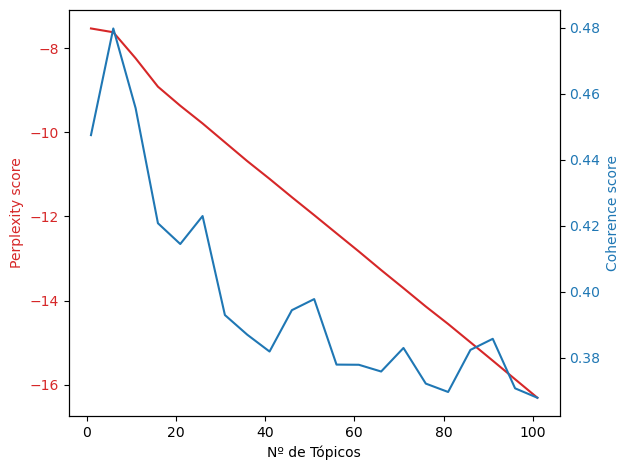

In [95]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=102; start=1; step=5;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('TO_Coherence Score_100 topicos.png')

plt.show()

In [96]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.4475  e valor de perplexidade de -7.5332
A quantidade de tópicos = 6  tem um valor de coerência de  0.4798  e valor de perplexidade de -7.6234
A quantidade de tópicos = 11  tem um valor de coerência de  0.4557  e valor de perplexidade de -8.2422
A quantidade de tópicos = 16  tem um valor de coerência de  0.4208  e valor de perplexidade de -8.9161
A quantidade de tópicos = 21  tem um valor de coerência de  0.4145  e valor de perplexidade de -9.3686
A quantidade de tópicos = 26  tem um valor de coerência de  0.423  e valor de perplexidade de -9.7897
A quantidade de tópicos = 31  tem um valor de coerência de  0.3929  e valor de perplexidade de -10.2371
A quantidade de tópicos = 36  tem um valor de coerência de  0.387  e valor de perplexidade de -10.6838
A quantidade de tópicos = 41  tem um valor de coerência de  0.3819  e valor de perplexidade de -11.1058
A quantidade de tópicos = 46  tem um valor de coerência de  0.3944  e valo

In [98]:
# Rodar a função (pode levar um tempo elevado):
model_list, coherence_values, perplexity_values = compute_performance(dictionary=dicionario,
                                                                           corpus=corpus,
                                                                           texts=df['Stem'],
                                                                           start=1,
                                                                           limit=31,
                                                                           step=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [16:25<00:00, 32.85s/it]


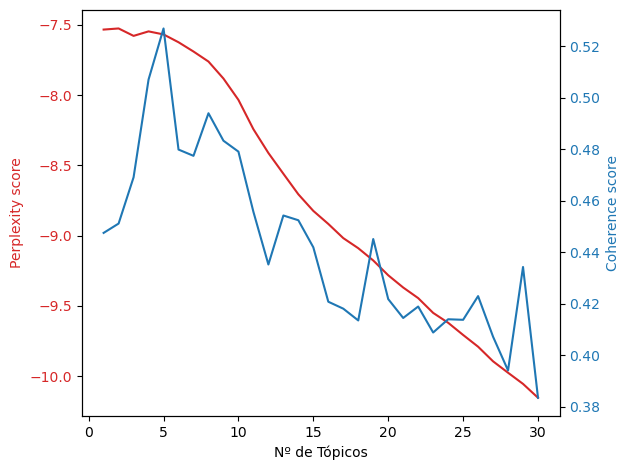

In [99]:
# Gráfico dos valores de coerência e perplexidade para cada nº de tópicos testado:
limit=31; start=1; step=1;
x = range(start, limit, step)
fig, ax1 = plt.subplots()
color = 'tab:red'
plt.xlabel("Nº de Tópicos")
plt.ylabel("Perplexity score", color=color)
ax1.plot(x, perplexity_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # 2º eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Coherence score', color=color) 
ax2.plot(x, coherence_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Salvar imagem:
plt.savefig('TO_Coherence Score_31 topicos.png')

plt.show()

In [100]:
# Lista dos valores de coerência:
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("A quantidade de tópicos =", m,
          " tem um valor de coerência de ", round(cv, 4),
          " e valor de perplexidade de", round(per, 4))

A quantidade de tópicos = 1  tem um valor de coerência de  0.4475  e valor de perplexidade de -7.5332
A quantidade de tópicos = 2  tem um valor de coerência de  0.4511  e valor de perplexidade de -7.5254
A quantidade de tópicos = 3  tem um valor de coerência de  0.4691  e valor de perplexidade de -7.5781
A quantidade de tópicos = 4  tem um valor de coerência de  0.507  e valor de perplexidade de -7.5461
A quantidade de tópicos = 5  tem um valor de coerência de  0.5268  e valor de perplexidade de -7.5678
A quantidade de tópicos = 6  tem um valor de coerência de  0.4798  e valor de perplexidade de -7.6234
A quantidade de tópicos = 7  tem um valor de coerência de  0.4774  e valor de perplexidade de -7.6895
A quantidade de tópicos = 8  tem um valor de coerência de  0.4939  e valor de perplexidade de -7.7608
A quantidade de tópicos = 9  tem um valor de coerência de  0.4833  e valor de perplexidade de -7.8817
A quantidade de tópicos = 10  tem um valor de coerência de  0.479  e valor de perpl

In [118]:
# Valor escolhido para coherence score foi 14 tópicos (coherence score = 0.5268):
# Número de tópicos
num_topicos = 5

In [119]:
# Inputar os dados e rodar o modelo LDA:
modelo_lda = LdaModel(corpus=corpus,
                      id2word=dicionario,
                      num_topics=num_topicos,
                      random_state=42,
                      per_word_topics=True)

In [120]:
# Imprimir os tópicos:
for topic_id in range(num_topicos):
    print(f"Topic {topic_id}: {modelo_lda.show_topic(topic_id)}")

Topic 0: [('estud', 0.013976733), ('numer', 0.011882968), ('problem', 0.009407998), ('ano', 0.0075632846), ('objet', 0.0073752357), ('nao', 0.0071704225), ('utiliz', 0.007005926), ('trabalh', 0.0067303875), ('habil', 0.0063390154), ('uso', 0.0061195185)]
Topic 1: [('text', 0.018459817), ('estud', 0.016220551), ('habil', 0.013770048), ('leit', 0.009659082), ('produca', 0.009464554), ('ano', 0.0094024995), ('gener', 0.00818619), ('difer', 0.0066670664), ('analis', 0.0061835), ('identific', 0.005961551)]
Topic 2: [('estud', 0.020727292), ('habil', 0.020277005), ('text', 0.017431797), ('trabalh', 0.011309816), ('geograf', 0.010365084), ('profes', 0.008294458), ('produca', 0.007895615), ('pesquis', 0.0069158557), ('pod', 0.0066206176), ('dad', 0.006268563)]
Topic 3: [('religi', 0.0137804), ('cult', 0.013503949), ('difer', 0.013235182), ('brasil', 0.010948292), ('tocantim', 0.010414486), ('curricul', 0.009738631), ('conhec', 0.00970493), ('document', 0.00823301), ('natur', 0.008191486), ('id

### Visualizações:

In [121]:
# Visualização dos tópicos:
visualizacao_BNCC = pyLDAvis.gensim_models.prepare(modelo_lda, corpus, dicionario, n_jobs=1)

In [122]:
# Salvar a visualização como um arquivo HTML:
pyLDAvis.save_html(visualizacao_BNCC, r"TO_visualizacao_BNCC_5_topicos.html")

### Distribuição de palavras por frase:

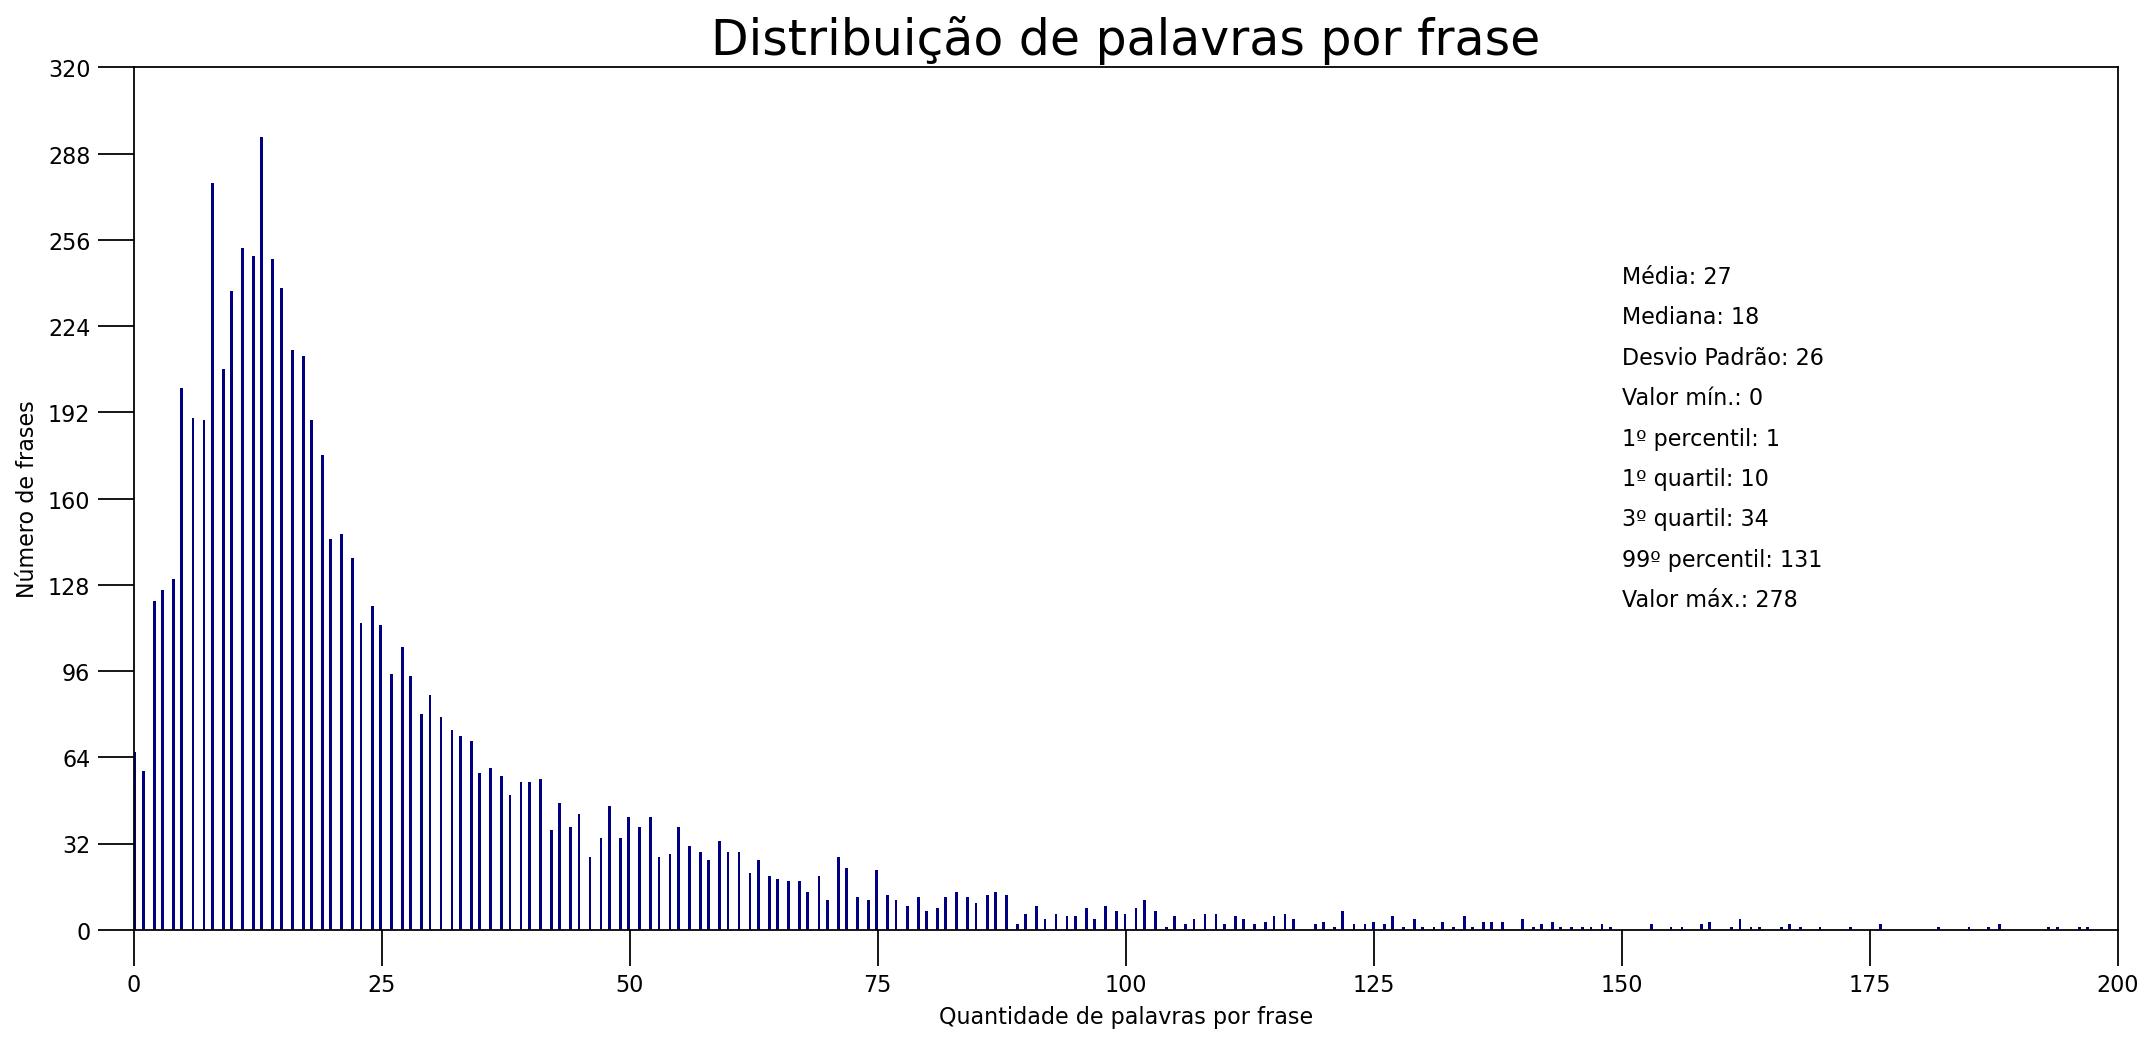

In [128]:
doc_lens = [len(d) for d in df['Stem']]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(150, 240, "Média: " + str(round(np.mean(doc_lens))))
plt.text(150, 225, "Mediana: " + str(round(np.median(doc_lens))))
plt.text(150, 210, "Desvio Padrão: " + str(round(np.std(doc_lens))))
plt.text(150, 195, "Valor mín.: " + str(round(np.min(doc_lens))))
plt.text(150, 180, "1º percentil: " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(150, 165, "1º quartil: " + str(round(np.quantile(doc_lens, q=0.25))))
plt.text(150, 150, "3º quartil: " + str(round(np.quantile(doc_lens, q=0.75))))
plt.text(150, 135, "99º percentil: " + str(round(np.quantile(doc_lens, q=0.99))))
plt.text(150, 120, "Valor máx.: " + str(round(np.max(doc_lens))))

plt.gca().set(xlim=(0, 200), ylim=(0, 320), ylabel='Número de frases', xlabel='Quantidade de palavras por frase')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,200,9))
plt.yticks(np.linspace(0,320,11))
plt.title('Distribuição de palavras por frase', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('TO_Distribuicao_de_palavras_por_frase.png')

plt.show()

### Frequência de palavras em todo o documento:

In [129]:
# Concatenar todas as strings em uma única lista de palavras:
palavras = [palavra for lista in df['Stem'].values for palavra in lista]

# Calcular a frequência das palavras:
freq_dist = FreqDist(palavras)

# Obter as palavras mais frequentes:
top30_palavras = freq_dist.most_common(30)

# Criar um DataFrame com as palavras e suas frequências:
top30_palavras_df = pd.DataFrame(top30_palavras, columns=['Palavra', 'Frequência'])

# Imprimir o DataFrame:
top30_palavras_df

,Palavra,Frequência
0,text,2670
1,estud,2222
2,habil,2195
3,difer,1495
4,leit,1306
5,lingu,1163
6,ano,1113
7,conhec,1097
8,objet,1017
9,curricul,1008


"pra" é a raiz de prática.

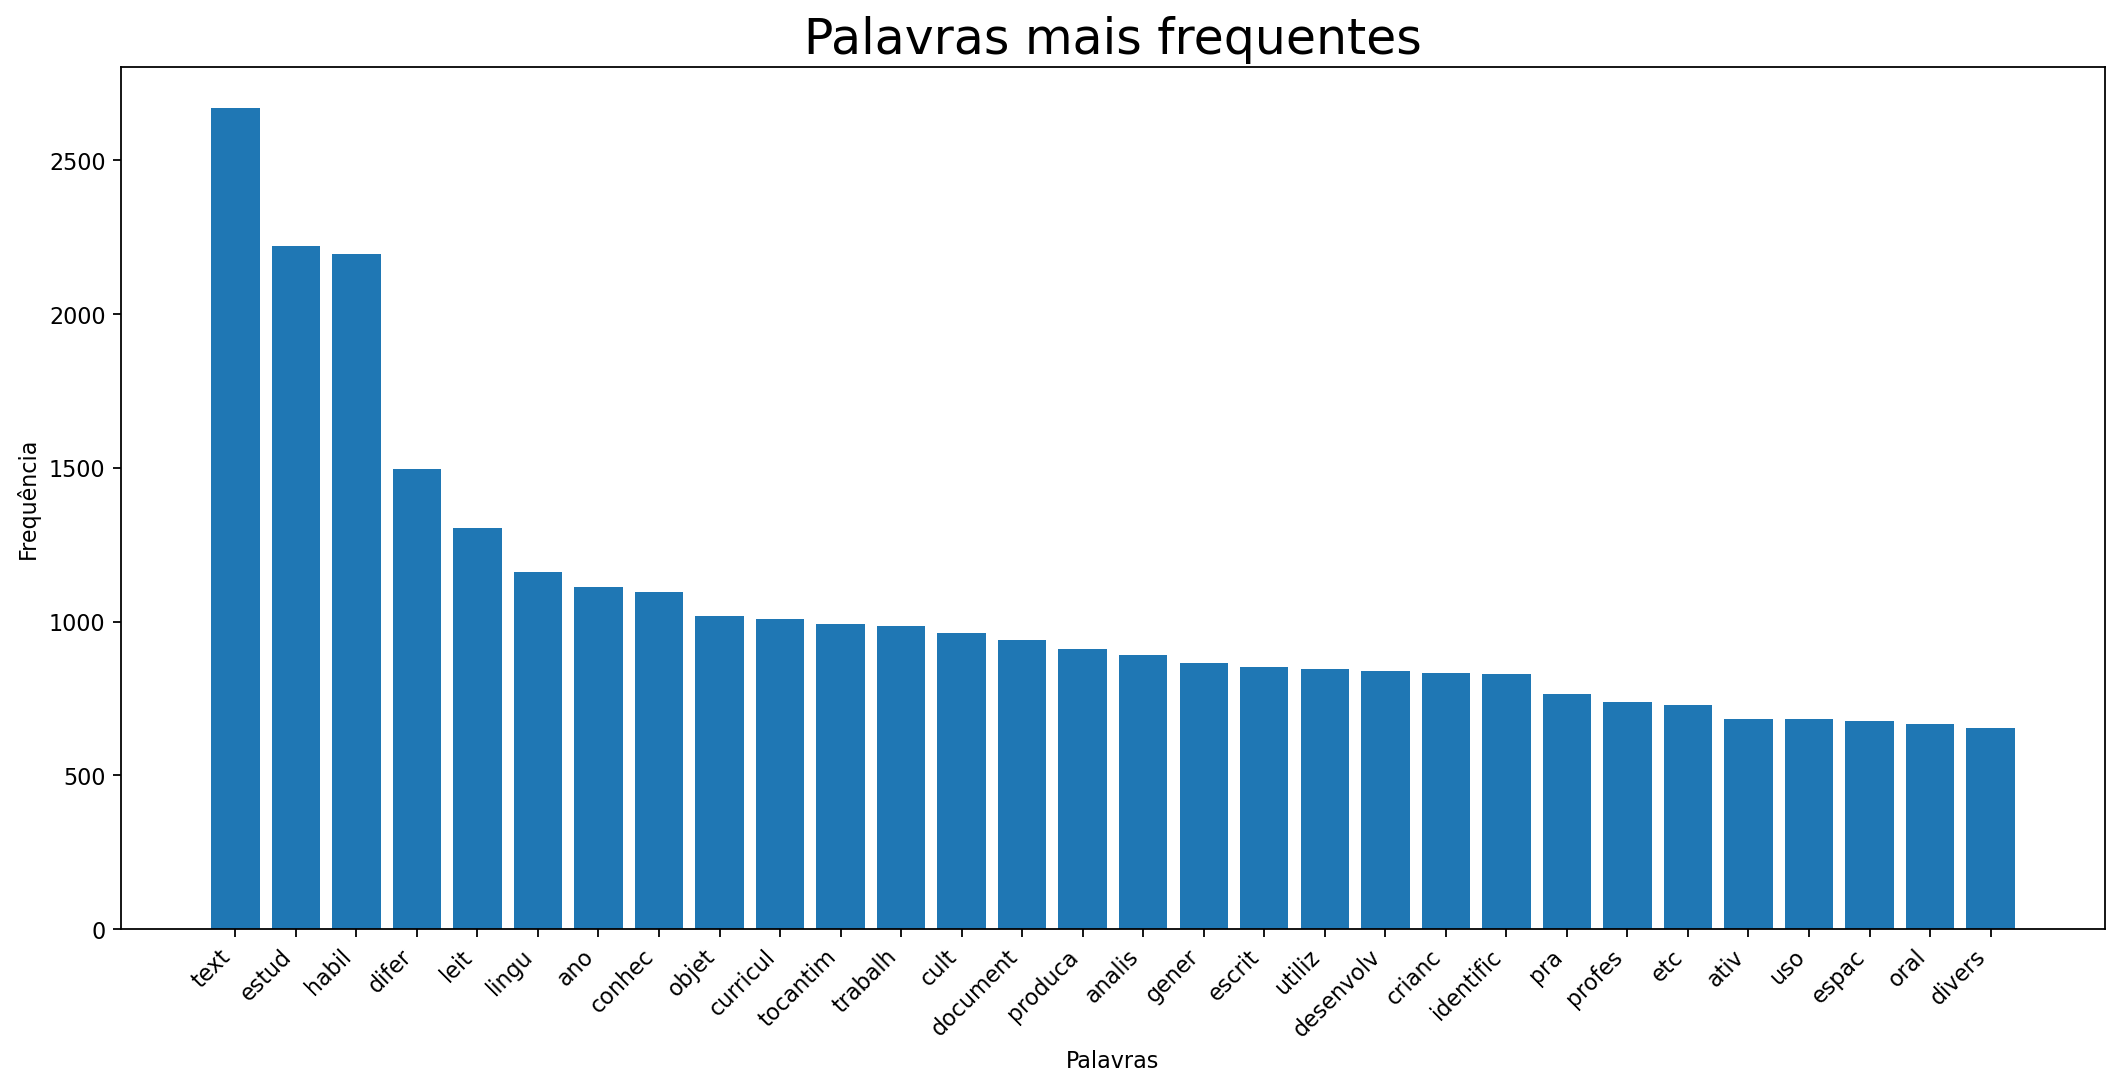

In [130]:
# Criar um gráfico de barras com as palavras mais frequentes:
plt.figure(figsize=(16,7), dpi=160)
plt.bar(top30_palavras_df['Palavra'], top30_palavras_df['Frequência'])
plt.title('Palavras mais frequentes', fontdict=dict(size=22))
plt.xlabel('Palavras')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Frequência')

# Salvar imagem:
plt.savefig('TO_Palavras mais frequentes.png')

plt.show()

### Nuvem de palavras para todo o documento:

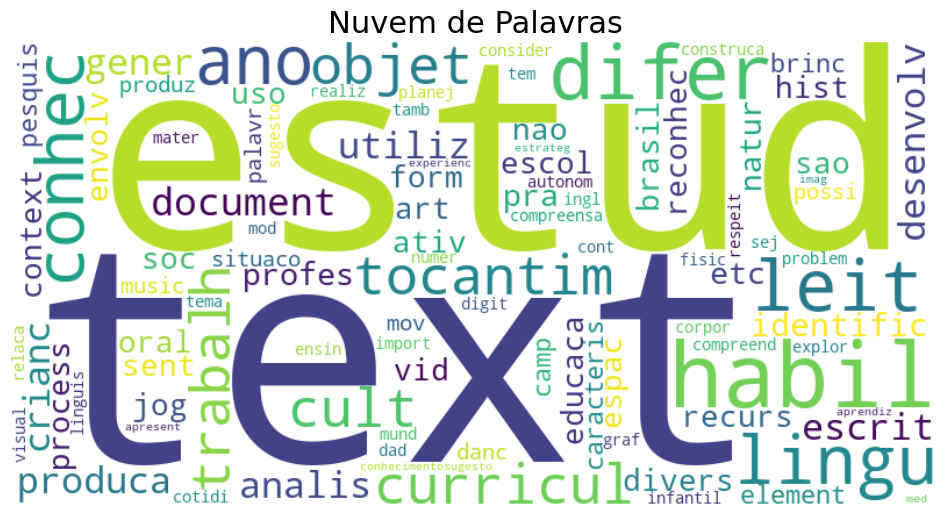

In [131]:
# Criar uma nuvem de palavras:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras', fontdict=dict(size=22))

# Salvar imagem:
plt.savefig('TO_Nuvem de palavras_corpus.png')

plt.show()

### Frequência de palavras em cada tópico:

In [132]:
# Criar DataFrame com frequência das palavras no corpus e relevância no tópico:
topics = modelo_lda.show_topics(num_topics=num_topicos, formatted=False)
data_flat = [w for w_list in df['Stem'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_topicos = pd.DataFrame(out, columns=['Stem', 'topic_id', 'relevancia', 'frequencia'])

C:\Users\hugob\AppData\Local\Temp\ipykernel_23940\1159437844.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_23940\1159437844.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_23940\1159437844.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
C:\Users\hugob\AppData\Local\Temp\ipykernel_23940\1159437844.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontal

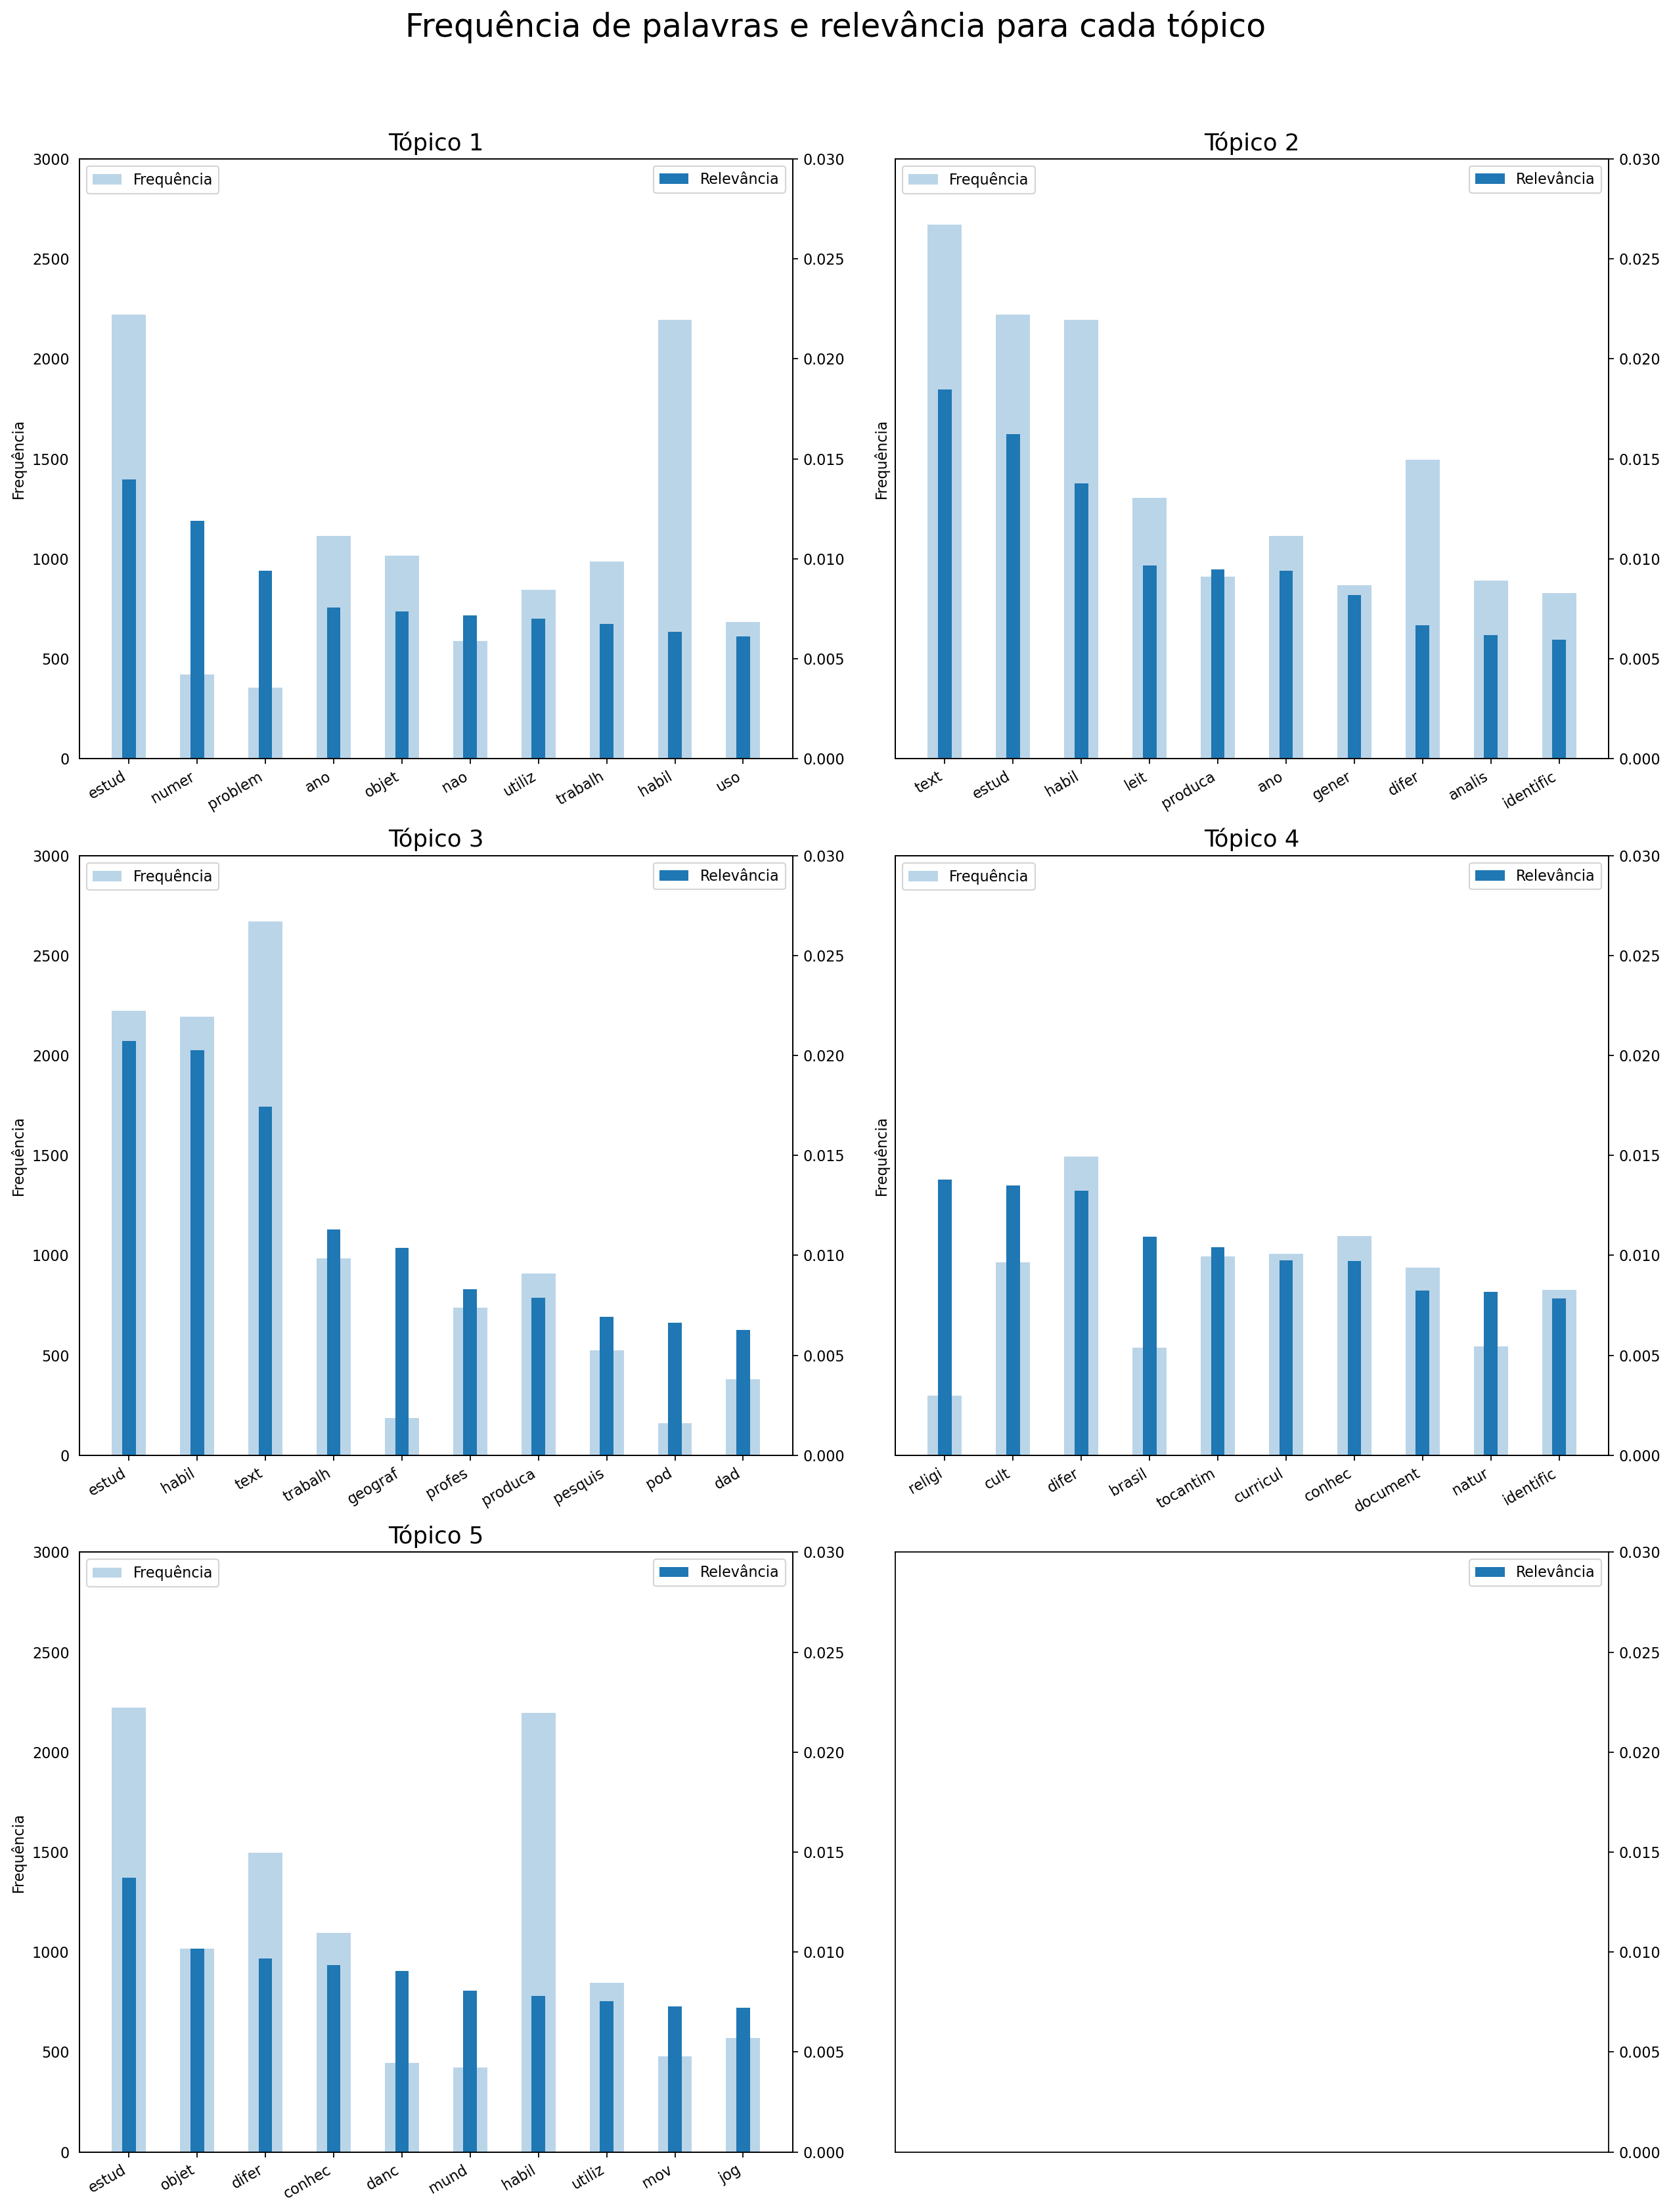

In [136]:
# Plotar contagem de palavras e pesos das palavras mais relevantes:
fig, axes = plt.subplots(3, 2, figsize=(16,20), sharey=True, dpi=160)

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='Stem', height="frequencia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.5, alpha=0.3, label='Frequência')
    ax_twin = ax.twinx()
    ax_twin.bar(x='Stem', height="relevancia", data=df_topicos.loc[df_topicos.topic_id==i, :], width=0.2, label='Relevância')
    ax.set_ylabel('Frequência')
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3000)
    ax.set_title('Tópico ' + str(i+1), fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_topicos.loc[df_topicos.topic_id==i, 'Stem'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

# Excluir o 66º subplot (na 3ª linha e 2ª coluna):
fig.delaxes(axes[2, 1])
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Frequência de palavras e relevância para cada tópico', fontsize=22, y=1.05)

# Salvar imagem:
plt.savefig('TO_Frequencia e relevancia de palavras por topico.png')

plt.show()

### Nuvem de palavras para cada tópico:

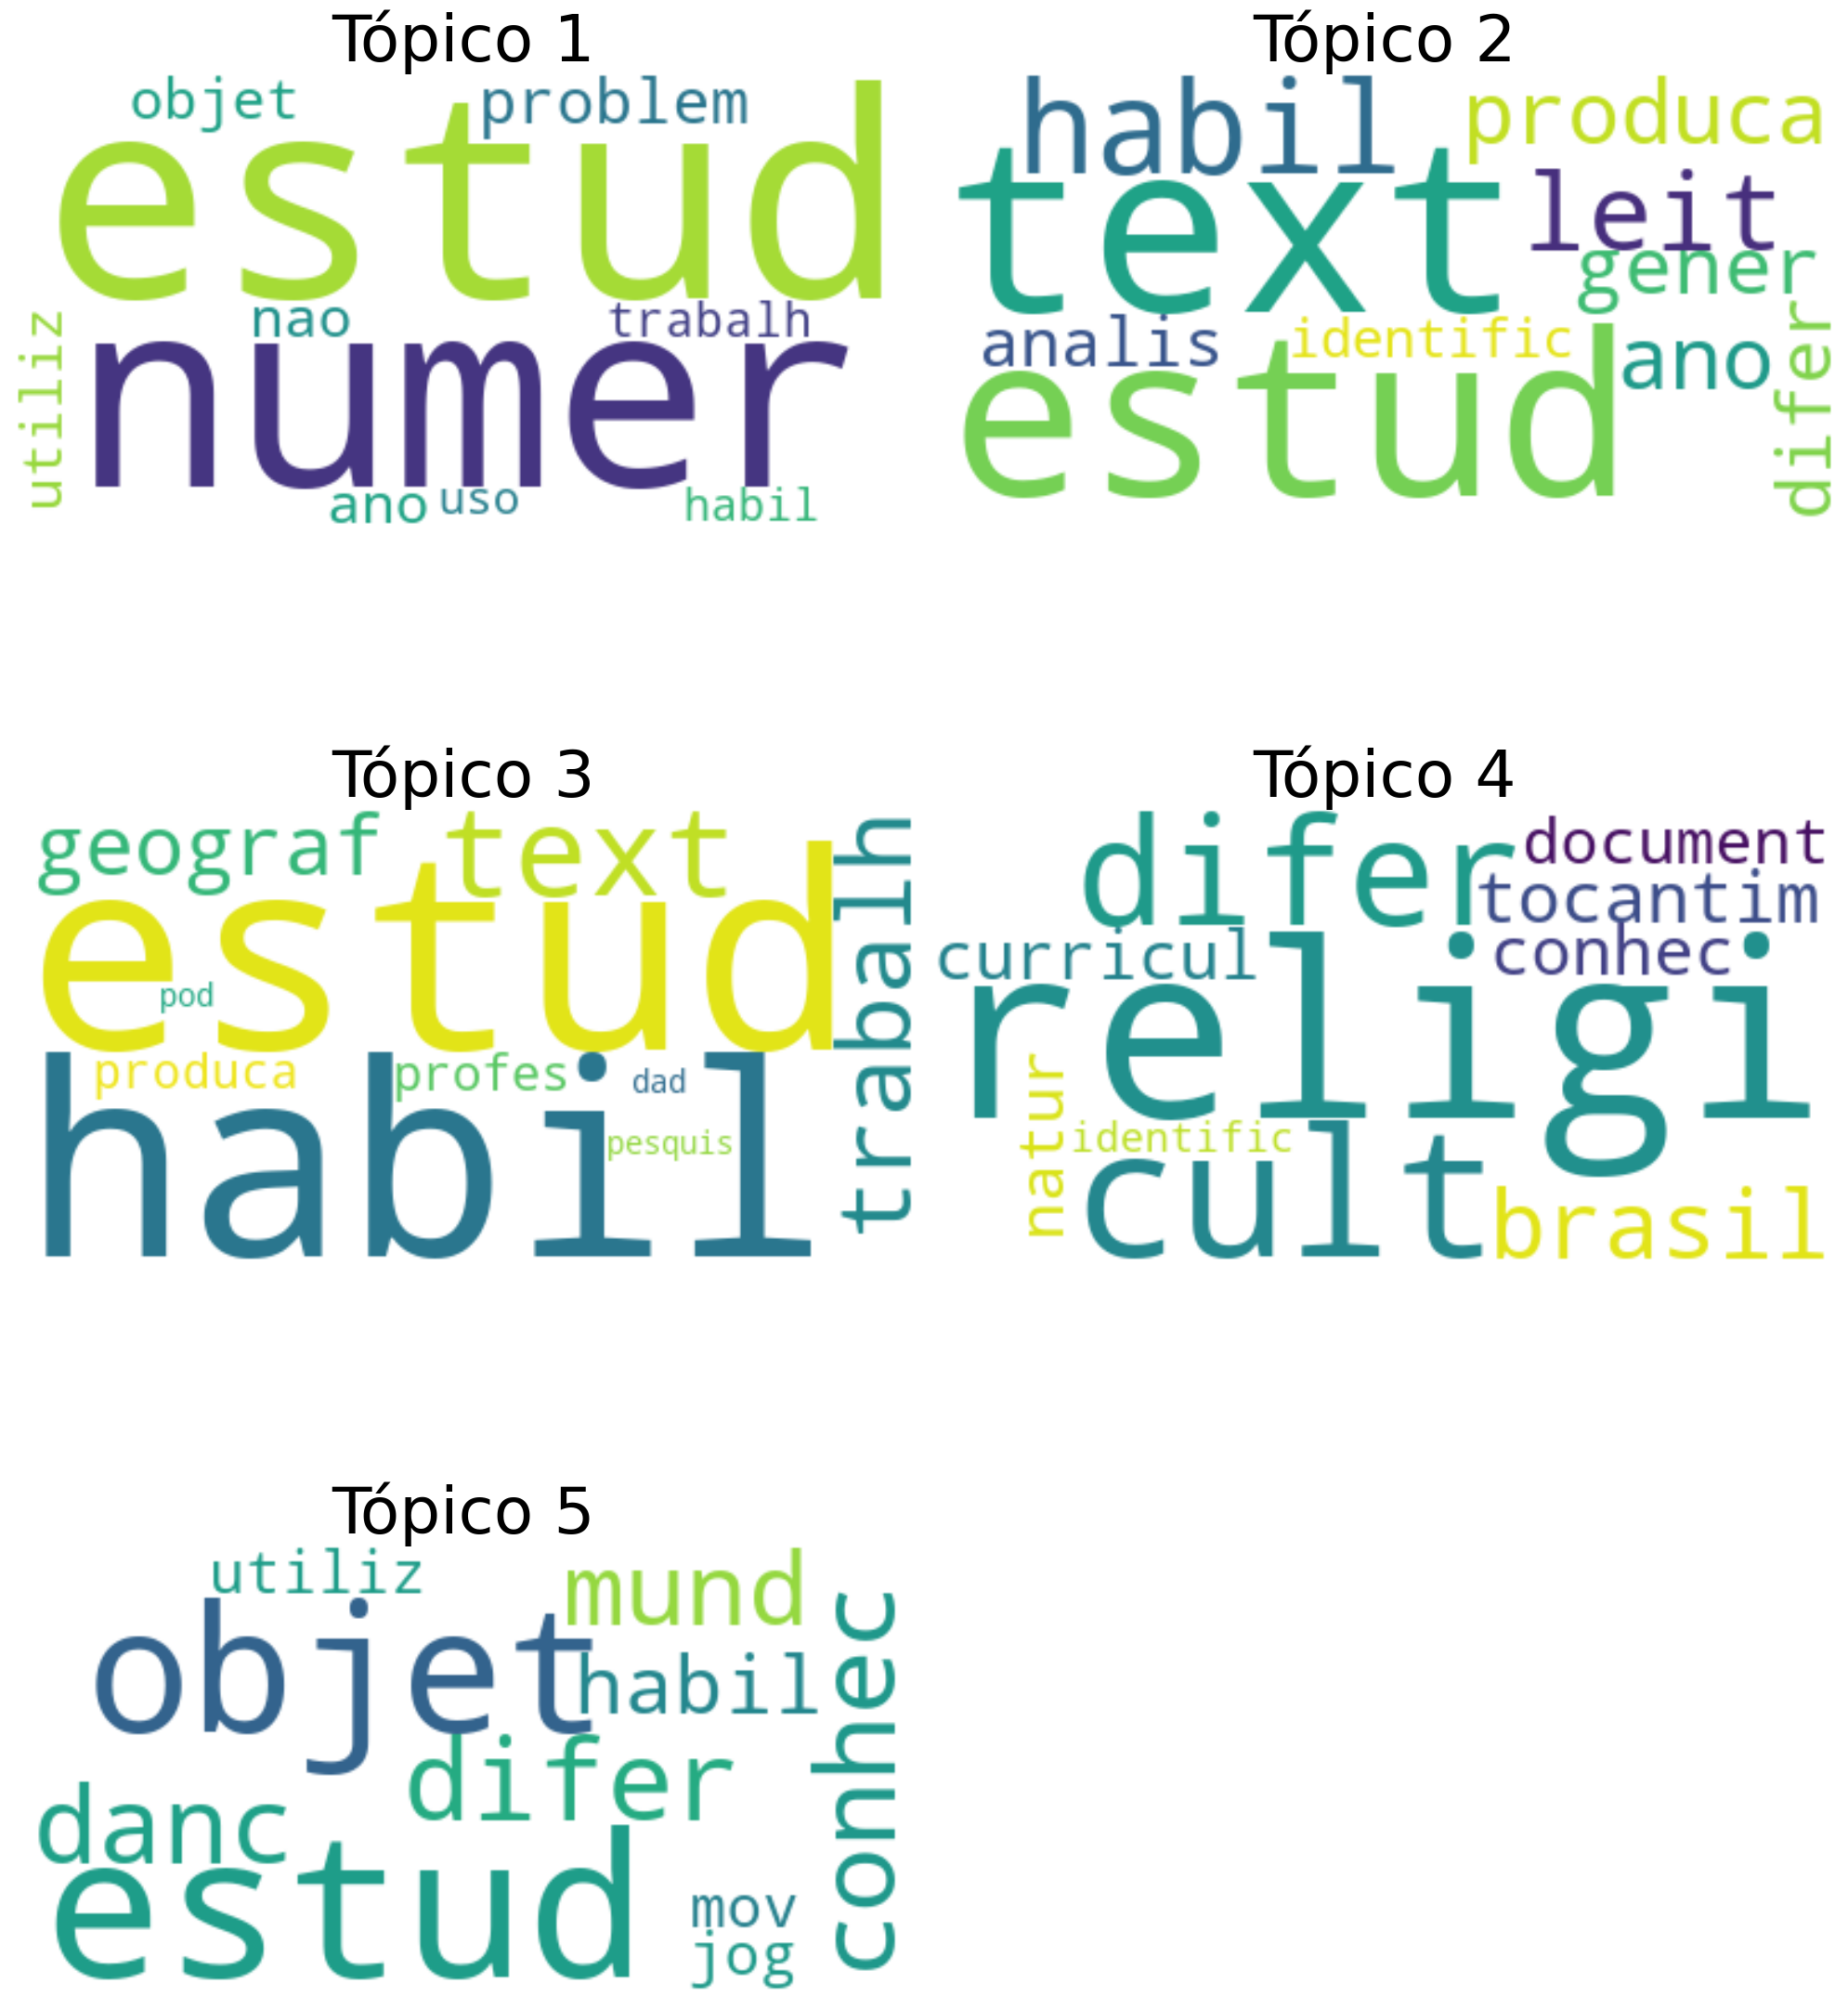

In [138]:
# Configuração do layout dos subplots
num_linhas = 3
num_colunas = 2

# Calcula o número total de subplots necessários
num_subplots = min(num_topicos, num_linhas * num_colunas)

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(20, 25)) 

for topico_id in range(num_subplots):
    # Obter as palavras e frequências associados ao tópico:
    topico_palavras_pesos = modelo_lda.show_topic(topico_id)
    
    # Criar um dicionário de contagem de palavras e pesos:
    contagem_palavras = {palavra: peso for palavra, peso in topico_palavras_pesos}
    
    # Criar o objeto WordCloud:
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(contagem_palavras)
    
    # Adicionar subplot ao layout
    linha = topico_id // num_colunas
    coluna = topico_id % num_colunas
    axs[linha, coluna].imshow(wordcloud, interpolation='bilinear')
    axs[linha, coluna].set_title(f'Tópico {topico_id + 1}', fontdict=dict(size=50))
    axs[linha, coluna].axis('off')

# Colocar o último subplot na última linha entre as duas colunas:
if num_topicos % num_colunas == 1:
    axs[-1, 0].axis('off')  # Desativa os eixos do último subplot na última linha
    axs[-1, 1].remove()     # Remove o último subplot na última linha, segunda coluna
    
# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Salvar imagem:
plt.savefig('TO_Nuvem de palavras por topico.png')

plt.show()